# EDA for Paired Dataset (paired_affirmations.csv)

This notebook performs exploratory data analysis (EDA) on the paired tweet-affirmation dataset. It computes and visualizes distributions of text length, sentiment and tag frequency, word clouds, and token counts using GPT-2's tokenizer. These insights help inform model training constraints and dataset quality. 

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from transformers import GPT2TokenizerFast
import re

/home/qlh2976/miniconda3/envs/affirmgen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Preview Data

In [2]:
#load the final paired dataset
df = pd.read_csv("paired_affirmations.csv")
#display the first 5 rows of the dataframe
df.head()
#print summary of column types, null values, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114601 entries, 0 to 114600
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Input            114601 non-null  object
 1   Output           114601 non-null  object
 2   Emotion_Label    114601 non-null  object
 3   Affirmation_Tag  114601 non-null  object
dtypes: object(4)
memory usage: 3.5+ MB


## Check for Missing or Duplicated Values

In [3]:
#count number of missing (NaN) values in each column
df.isnull().sum()
#count number of duplicate rows in the dataset
df.duplicated().sum()

np.int64(0)

## Basic Text Stats

In [4]:
#compute length (number of characters) of input and output texts
#length of tweet text
df['input_len'] = df['Input'].astype(str).apply(len)
#length of affirmation text
df['output_len'] = df['Output'].astype(str).apply(len)

#show basic statistics (min, max, mean, etc.) for both lengths
df[['input_len', 'output_len']].describe()

,input_len,output_len
count,114601.000000,114601.000000
mean,70.918587,40.822864
std,36.505868,11.317585
min,1.000000,10.000000
25%,41.000000,33.000000
50%,65.000000,41.000000
75%,100.000000,49.000000
max,167.000000,79.000000


## Visualization

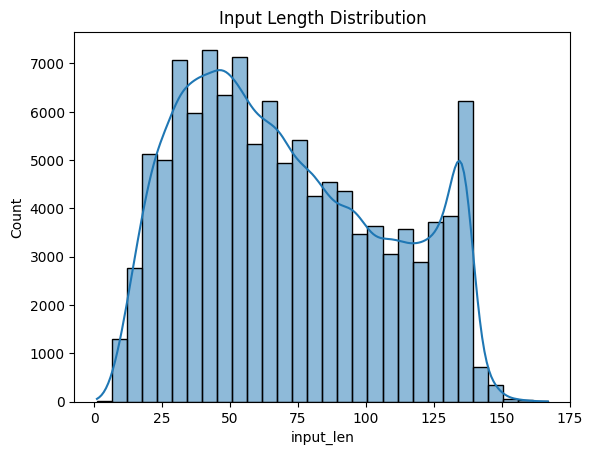

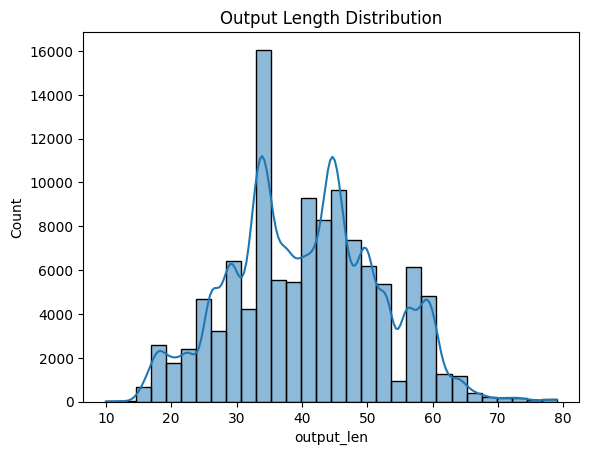

In [5]:
#plot distribution of input lengths with KDE curve overlay
sns.histplot(df['input_len'], kde=True, bins=30).set(title="Input Length Distribution")
#save the plot
plt.savefig("../results/eda/input_length_distribution.png", bbox_inches='tight')
#display plot
plt.show()

#plot distribution of output lengths similarly
sns.histplot(df['output_len'], kde=True, bins=30).set(title="Output Length Distribution")
plt.savefig("../results/eda/output_length_distribution.png", bbox_inches='tight')
plt.show()

## Tag Distrbiutions

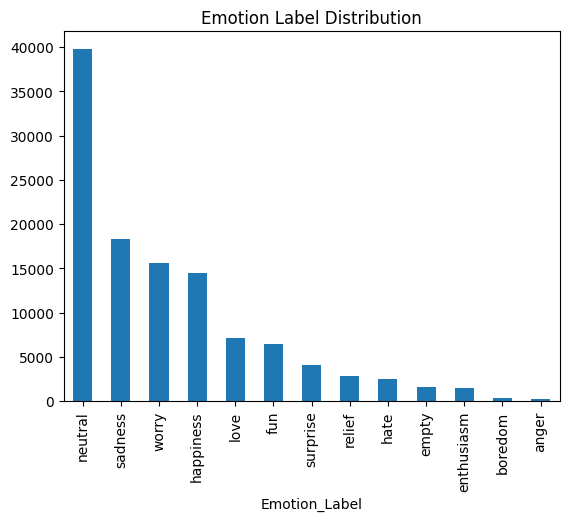

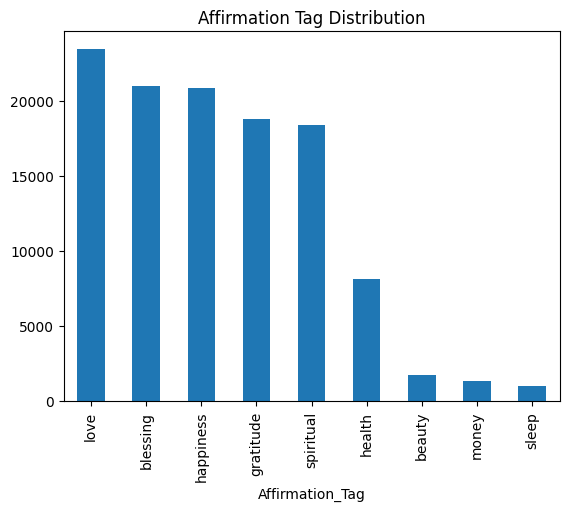

In [6]:
#bar plot showing frequency of each emotion label
df['Emotion_Label'].value_counts().plot(kind='bar', title="Emotion Label Distribution")
plt.savefig("../results/eda/emotion_label_distribution.png", bbox_inches='tight')
plt.show()

#bar plot showing frequency of each affirmation tag
df['Affirmation_Tag'].value_counts().plot(kind='bar', title="Affirmation Tag Distribution")
plt.savefig("../results/eda/affirmation_tag_distribution.png", bbox_inches='tight')
plt.show()

## Most Common Words

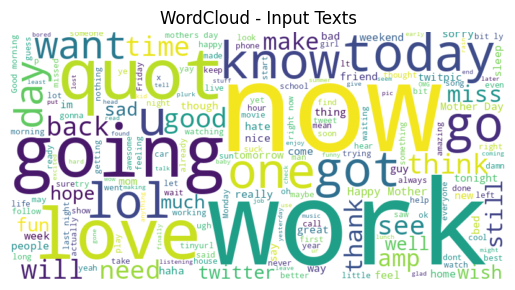

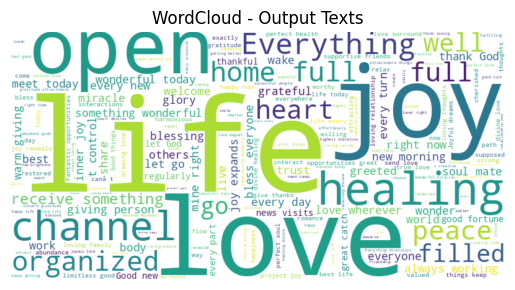

In [7]:
#combine all input texts into a single string for word cloud
all_inputs = " ".join(df['Input'].astype(str).tolist())
#generate word cloud image for input texts
input_wc = WordCloud(width=800, height=400, background_color='white').generate(all_inputs)

#display the word cloud image
plt.imshow(input_wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Input Texts")
plt.savefig("../results/eda/wordCloud_input_texts.png", bbox_inches='tight')
plt.show()



# repeat same steps for output (affirmation) texts
all_inputs = " ".join(df['Output'].astype(str).tolist())
input_wc = WordCloud(width=800, height=400, background_color='white').generate(all_inputs)

plt.imshow(input_wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Output Texts")
plt.savefig("../results/eda/wordCloud_output_texts.png", bbox_inches='tight')
plt.show()

## Tag vs. Input/Output Length

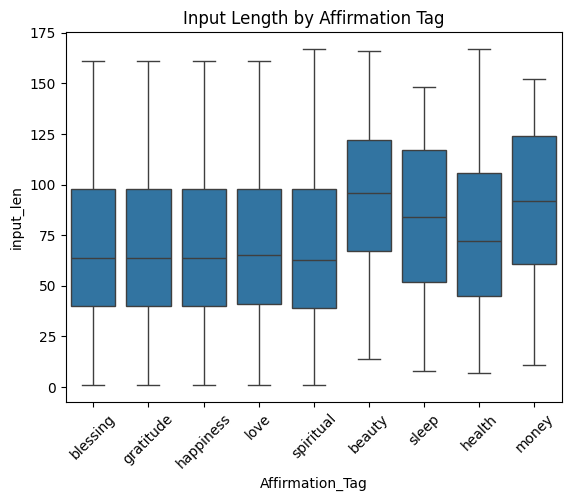

In [8]:
#box plot showing distribution of input text lengths grouped by affirmation tag
sns.boxplot(data=df, x='Affirmation_Tag', y='input_len')
plt.title("Input Length by Affirmation Tag")
#rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.savefig("../results/eda/input_length_by_affirmation_tag.png", bbox_inches='tight')
plt.show()

## Distribution of Combined Lengths

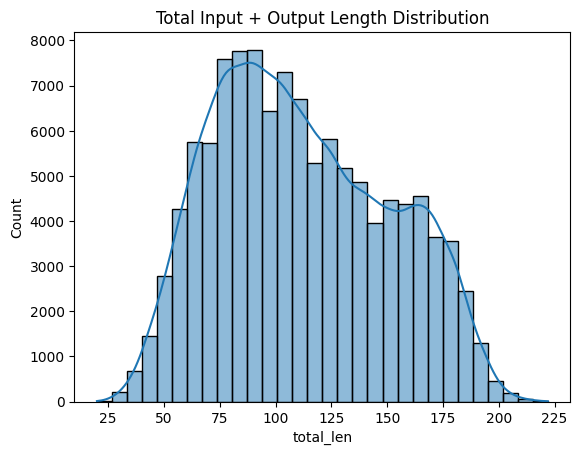

In [9]:
#add a new column that combines input + output length for each pair
df['total_len'] = df['input_len'] + df['output_len']
#plot distribution of total length
sns.histplot(df['total_len'], bins=30, kde=True)
plt.title("Total Input + Output Length Distribution")
plt.savefig("../results/eda/total_input_output_length_distribution.png", bbox_inches='tight')
plt.show()

## Heatmap of Emotions vs. Affirmation_Tag

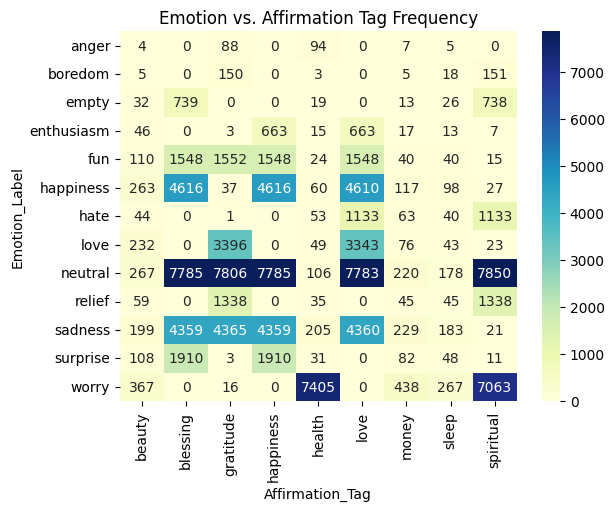

In [10]:
#create a frequency table of emotion vs. tag (2D matrix)
heatmap_data = pd.crosstab(df['Emotion_Label'], df['Affirmation_Tag'])
#plot heatmap showing joint frequency counts
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Emotion vs. Affirmation Tag Frequency")
plt.savefig("../results/eda/emotion_vs_tag_heatmap.png", bbox_inches='tight')
plt.show()

## Length Threshold Coverage
How many pairs exceed 256 or 512 tokens (important for GPT2)?

In [11]:
#recalculate total character length
df['total_len'] = df['input_len'] + df['output_len']
#print how many samples exceed 256 and 512 characters (important for token limits)
print("Pairs >256 characters:", (df['total_len'] > 256).sum())
print("Pairs >512 characters:", (df['total_len'] > 512).sum())

Pairs >256 characters: 0
Pairs >512 characters: 0


## Token Length Analysis (GPT-2 Limit Awareness)

/home/qlh2976/miniconda3/envs/affirmgen/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


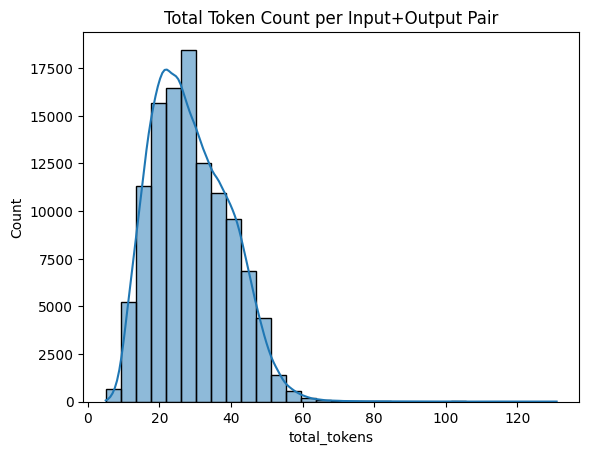

Pairs over 512 tokens:  0
Pairs over 1024 tokens (GPT-2 limit):  0


In [12]:
#load GPT-2 tokenizer for counting tokens instead of characters
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

#count number of tokens in each input (tweet) using GPT-2 tokenizer
df['num_tokens_input'] = df['Input'].apply(lambda x: len(tokenizer.encode(x)))
#count number of tokens in each output (affirmation)
df['num_tokens_output'] = df['Output'].apply(lambda x: len(tokenizer.encode(x)))
#sum total token count per sample
df['total_tokens'] = df['num_tokens_input'] + df['num_tokens_output']

#plot histogram of total token count distribution
sns.histplot(df['total_tokens'], bins=30, kde=True)
plt.title("Total Token Count per Input+Output Pair")
plt.savefig("../results/eda/total_token_distribution.png", bbox_inches='tight')
plt.show()

#print counts of samples that exceed token length thresholds (GPT-2's max is 1024 tokens)
print("Pairs over 512 tokens: ", (df['total_tokens'] > 512).sum())
print("Pairs over 1024 tokens (GPT-2 limit): ", (df['total_tokens'] > 1024).sum())